**Название проекта:**

Проект по А/B-тестированию

**Цель исследования:**

Оценка результатов A/B-теста


**Краткое описание проекта:**

В распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

*Техническое задание*
- название теста: recommender_system_test;
- группы: А (контрольная), B (новая платёжная воронка);
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  - конверсии в просмотр карточек товаров — событие product_page
  - просмотры корзины — product_cart
  - покупки — purchase.




**Описание начальных данных:**

- датасет ab_project_marketing_events.csv (календарь маркетинговых событий на 2020 год)
  - name — название маркетингового события;
  - regions — регионы, в которых будет проводиться рекламная кампания;
  - start_dt — дата начала кампании;
  - finish_dt — дата завершения кампании.


- датасет final_ab_new_users.csv (все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года)
  - user_id — идентификатор пользователя;
  - first_date — дата регистрации;
  - region — регион пользователя;
  - device — устройство, с которого происходила регистрация.


- датасет final_ab_events.csv (все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года)
  - user_id — идентификатор пользователя;
  - event_dt — дата и время события;
  - event_name — тип события;
  - details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.


- датасет final_ab_participants.csv (таблица участников тестов)
  - user_id — идентификатор пользователя;
  - ab_test — название теста;
  - group — группа пользователя.


**Ход исследования:**

1. Загрузка данных и подготовка их к анализу
2. Предобработка данных
3. Оценка корректности проведения теста
4. Исследовательский анализ данных
5. Оценка результатов A/B-тестирования
6. Выводы и общее заключение о корректности проведения теста

# 1. Загрузка данных и подготовка их к анализу

## Обзор данных

In [ ]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
from statsmodels.stats.multitest import multipletests
from datetime import datetime, timedelta
import datetime as dt
import plotly.express as px
import numpy as np

In [ ]:
# загружаем календарь маркетинговых событий на 2020 год
calendar = pd.read_csv('/content/drive/MyDrive/ЯПрактикум - АЛЛА/Спринт 13. Выпускной проект/Проект по А В - тестрованию/ab_project_marketing_events.csv')

In [ ]:
# загружаем данные о пользователях
users = pd.read_csv('/content/drive/MyDrive/ЯПрактикум - АЛЛА/Спринт 13. Выпускной проект/Проект по А В - тестрованию/final_ab_new_users.csv')

In [ ]:
# загружаем данные о событиях
events = pd.read_csv('/content/drive/MyDrive/ЯПрактикум - АЛЛА/Спринт 13. Выпускной проект/Проект по А В - тестрованию/final_ab_events.csv')

In [ ]:
# загружаем данные об участниках А/В - тестов
ab_test = pd.read_csv('/content/drive/MyDrive/ЯПрактикум - АЛЛА/Спринт 13. Выпускной проект/Проект по А В - тестрованию/final_ab_participants.csv')

In [ ]:
# откроем таблицу calendar и посмотрим общую информацию о ней
calendar.info()
calendar.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [ ]:
# откроем таблицу users и посмотрим общую информацию о ней
users.info()
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [ ]:
# откроем таблицу events и посмотрим общую информацию о ней
events.info()
events.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [ ]:
# откроем таблицу ab_test и посмотрим общую информацию о ней
ab_test.info()
ab_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Что необходимо исправить:

- таблица calendar:
  - наименование столбца regions на region
  - тип в столбцах start_dt и finish_dt на дату
  
- таблица users:
  - наименование столбца first_date на registration_date
  - тип в столбце first_date (registration_date) на дату
  
- таблица events:
  - тип в столбце event_dt на datetime
  - заменить пропуски в столбце details на 0
  
- проверить все таблицы на наличие дубликатов

# 2. Предобработка данных

## Изменение типов данных

In [ ]:
# преобразуем данные о времени
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'])
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%dT')
                       

## Обработка названий столбцов

In [ ]:
# переименуем названия столбцов
calendar = calendar.rename(columns={
    'regions': 'region'
})

users = users.rename(columns={
    'first_date': 'registration_date'
})

## Обработка пропусков

In [ ]:
# проверим данные датасета events на наличие пропусков в %
pd.DataFrame(round(events.isna().mean()*100)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,86.000000


In [ ]:
# заменим пропуски в столбце details на '0'
events['details'] = events['details'].fillna(0)

In [ ]:
# посмотрим на природу пропусков
r=events[events['details']==0]
r['event_name'].value_counts()

login           189552
product_page    125563
product_cart     62462
Name: event_name, dtype: int64

Возможная причина отсутстия данных: часть пользователей не прошли регистрацию / не просмотрели страницу продукта / не дошли до корзины.

## Обработка дубликатов

In [ ]:
# проверим датасеты на наличие дубликатов
c_dub = calendar.duplicated().sum()
u_dub = users.duplicated().sum()
e_dub = events.duplicated().sum()
ab_dub = ab_test.duplicated().sum()

print('количество дубликатов в датасете calendar - {}'.format(c_dub))
print('количество дубликатов в датасете users - {}'.format(u_dub))
print('количество дубликатов в датасете events - {}'.format(e_dub))
print('количество дубликатов в датасете ab_test - {}'.format(ab_dub))



количество дубликатов в датасете calendar - 0
количество дубликатов в датасете users - 0
количество дубликатов в датасете events - 0
количество дубликатов в датасете ab_test - 0


## Проверка изменений

In [ ]:
# откроем таблицу calendar
calendar.info()
calendar.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   region     14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,region,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [ ]:
# откроем таблицу calendar
users.info()
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            61733 non-null  object        
 1   registration_date  61733 non-null  datetime64[ns]
 2   region             61733 non-null  object        
 3   device             61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,registration_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [ ]:
# откроем таблицу calendar
events.info()
events.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


В данном разделе обработаны все ошибки, обнаруженные на 1 этапе (загрузка и обзор данных)

# 3. Оценка корректности проведения теста

## Проверка корректности всех пунктов технического задания

### Периоды запуска и остановки теста

In [ ]:
# объединим таблицы users и events
users_events = users.merge(events, on='user_id', how='left')

# объединим таблицы users_events и ab_test
users_events_ab_test = users_events.merge(ab_test, on='user_id', how='left')

# отфильтруем итоговую таблицу по тестируемой группе
users_events_ab_test_period = users_events_ab_test.query('ab_test=="recommender_system_test"')
users_events_ab_test_period.head()

,user_id,registration_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,0.0,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,0.0,A,recommender_system_test
90,E6DE857AFBDC6102,2020-12-07,EU,PC,NaT,NaN,NaN,B,recommender_system_test
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,0.0,B,recommender_system_test
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,0.0,B,recommender_system_test


In [ ]:
# найдем минимальную и максимальную даты периода
min_date = users_events_ab_test_period['event_dt'].min()
max_date = users_events_ab_test_period['event_dt'].max()
max_date_u = users_events_ab_test_period['registration_date'].max()
print('дата запуска - {}'.format(min_date))
print('дата остановки набора новых пользователей- {}'.format(max_date_u))
print('дата остановки - {}'.format(max_date))


дата запуска - 2020-12-07 00:05:57
дата остановки набора новых пользователей- 2020-12-21 00:00:00
дата остановки - 2020-12-30 12:42:57


Обнаружено несовпадение в дате остановки теста

### Аудитория новых пользователей из региона EU

In [ ]:
# выведем всех пользователей по регионам
region_cnt= users_events_ab_test.groupby('region')['user_id'].nunique().reset_index()
region_cnt

,region,user_id
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


In [ ]:
# выведем новых пользователей из EU
ab_test_cnt = users_events_ab_test[users_events_ab_test['ab_test']=="recommender_system_test"]

ab_test_cnt = ab_test_cnt.groupby('region')['user_id'].nunique().reset_index()
ab_test_cnt.columns = ['region', 'user_id_eu']
ab_test_cnt

,region,user_id_eu
0,APAC,72
1,CIS,55
2,EU,6351
3,N.America,223


In [ ]:
# объединим таблицы region_cnt_ и ab_test_cnt
region_ab_test_cnt = region_cnt.merge(
        ab_test_cnt[['region', 'user_id_eu']], on='region', how='left'
    )

# посчитаем долюновых пользователей из ЕС
region_ab_test_cnt = region_ab_test_cnt[region_ab_test_cnt['region']=="EU"]
region_ab_test_cnt['ratio'] = (region_ab_test_cnt['user_id_eu']/region_ab_test_cnt['user_id'])*100
region_ab_test_cnt

,region,user_id,user_id_eu,ratio
2,EU,46270,6351,13.725956


Обнаружены несовпадения в доле новых пользователей из Европы: разница составляет 1,2% в меньшую сторону.

### Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%


In [ ]:
# отфильтруем таблицу 
users_login = users_events_ab_test.query('region=="EU" and ab_test=="recommender_system_test"')
users_login

# добавим столбец с лайфтаймом
users_login['lifetime'] = users_login['event_dt'] - users_login['registration_date']


# отфильтруем таблицу по поздней дате
users_login=users_login[users_login['lifetime']<='14 days 12:42:57']

# выведем пользователей по группам
# посчитаем долю пользователей по событию
unic_user_event = (users_login
                   .groupby('event_name')
                   .agg(number_of_users = ('user_id', 'nunique'))
                   .sort_values('number_of_users', ascending=False)
                   .assign(user_share = lambda x: x['number_of_users'] / users_login['user_id'].nunique()))

new_index = ['login', 'product_page', 'product_cart', 'purchase']
unic_user_event = unic_user_event.reindex(new_index)

unic_user_event

<ipython-input-25-78dbe826da6b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_login['lifetime'] = users_login['event_dt'] - users_login['registration_date']


,number_of_users,user_share
event_name,,
login,3480,0.999713
product_page,2178,0.625682
product_cart,1026,0.294743
purchase,1082,0.310830


In [ ]:
# login - регистрация пользователя
# product_page - страница продукта
# product_cart - корзина
# purchase - покупка

# построим воронку событий и посмотрим, сколько пользователей побывали на каждом из этапов
fig = go.Figure(go.Funnel(
    y = new_index,
    x = unic_user_event['number_of_users'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous+percent total",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 3, 2, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(title="Воронка событий", width=900, height=500)

fig.show()

## Проверка пересечений периодов проведения теста и маркетинговых активностей

In [ ]:
# отсортируем промо-календарь по дате старта
calendar.sort_values(by='start_dt')

,name,region,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


В период проведения теста попадают два мерояприятия - Christmas&New Year Promo (6 дней) и CIS New Year Gift Lottery (1 день)

## Аудитория теста

### Проверка наличия пользователей в двух тестах и группах одновременно

In [ ]:
# проверим, нет ли в данных пользователей, участвовавших в двух тестах сразу
general = users_events_ab_test.query('region=="EU"')
general.groupby('user_id')['ab_test'].nunique()[general.groupby('user_id')['ab_test'].nunique() > 1].index


Index(['001064FEAAB631A1', '00341D8401F0F665', '003B6786B4FF5B03',
       '0082295A41A867B5', '00E68F103C66C1F7', '00EFA157F7B6E1C4',
       '010DB4614355A4BB', '0151DAF505060E94', '01B9975CAE144B78',
       '020A95B66F363AFB',
       ...
       'FEA0C585A53E7027', 'FEC0BCA6C323872F', 'FEE7040D7D2F2968',
       'FF2174A1AA0EAD20', 'FF44696E39039D29', 'FF7BE2897FC0380D',
       'FF9A81323FA67D6E', 'FFC53FD45DDA5EE8', 'FFED90241D04503F',
       'FFF28D02B1EACBE1'],
      dtype='object', name='user_id', length=1602)

Выявлено 1602 пользователя, участвоваших сразу в двух тестах.

In [ ]:
# проверим, нет ли в данных пользователей, участвовавших в нескольких группах одного теста сразу
out = users_events_ab_test.query('region=="EU" and ab_test=="recommender_system_test"')

out.groupby('user_id')['group'].nunique()[out.groupby('user_id')['group'].nunique() > 1].index


Index([], dtype='object', name='user_id')

Таблица out пуста, можно сделать вывод, что нет пользователей, участвующих в двух и более группах одного теста сразу.

### Проверка количества пользователей в группах

In [ ]:
# выведем пользователей по группам
user_pivot = out[out['event_name'] == "login"]
user_pivot = user_pivot.pivot_table(index='group',values='user_id',aggfunc='nunique')
user_pivot['ratio'] = round(user_pivot['user_id']/user_pivot['user_id'].sum()*100)
user_pivot.sort_values('group', ascending=False).head()

,user_id,ratio
group,,
B,877,25.0
A,2604,75.0


В каждой группе есть пользователи. Различие в количестве пользователей значительное, что критично. Также количество участников теста намного ниже запланированного количества.

В данном разделе мы обнаружили:
- несовпадение в дате остановки теста
- несовпадения в доле новых пользователей из Европы: разница составляет 1,2% в меньшую сторону.
- несовпадения в количестве участников теста: больше запланированого на 351 участника.
- подтвердилась ожидаемая конверсия пользователей за первые 14 дней 
- период проведения теста пересекается в периодами двух мерояприятий - Christmas&New Year Promo (6 дней) и CIS New Year Gift Lottery (1 день)
- нет пользователей, участвующих в двух и более группах сразу
- различие в количестве пользователей в группах значительно выше 1%%, что критично.

# 4. Исследовательский анализ данных

### Определение количества событий на одного пользователя по группам

In [ ]:
real_test = users_events_ab_test.query('region=="EU" and ab_test=="recommender_system_test" and event_name == "login"')
real_test                                

,user_id,registration_date,region,device,event_dt,event_name,details,group,ab_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,0.0,A,recommender_system_test
158,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:53,login,0.0,B,recommender_system_test
160,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:27,login,0.0,B,recommender_system_test
162,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-10 18:18:24,login,0.0,B,recommender_system_test
164,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-16 20:35:47,login,0.0,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...
449806,574ACBC674BC385D,2020-12-20,EU,Mac,2020-12-20 04:15:43,login,0.0,A,recommender_system_test
449807,574ACBC674BC385D,2020-12-20,EU,Mac,2020-12-26 04:55:27,login,0.0,A,recommender_system_test
449814,0416B34D35C8C8B8,2020-12-20,EU,Android,2020-12-20 20:58:25,login,0.0,A,recommender_system_test
449815,0416B34D35C8C8B8,2020-12-20,EU,Android,2020-12-21 22:28:29,login,0.0,A,recommender_system_test


In [ ]:
# создадим выборки по группам А и В
real_test = users_events_ab_test.query('region=="EU" and ab_test=="recommender_system_test" and event_name == "login"')
group_a = real_test.query('group=="A"')
group_b = real_test.query('group=="B"')


In [ ]:
# посмотрим сколько всего событий в группах
event_cnt_a = len(group_a)
event_cnt_b = len(group_b)
print('Всего событий в группе А: {}'.format(event_cnt_a))
print('Всего событий в группе B: {}'.format(event_cnt_b))

Всего событий в группе А: 8124
Всего событий в группе B: 2471


In [ ]:
# посмотрим сколько всего пользователей в группах
user_cnt_a = group_a['user_id'].nunique()
user_cnt_b = group_b['user_id'].nunique()
print('Всего пользователей в группе А: {}'.format(user_cnt_a))
print('Всего пользователей в группе B: {}'.format(user_cnt_b))

Всего пользователей в группе А: 2604
Всего пользователей в группе B: 877


In [ ]:
# вычислим среднее количество событий на одного пользователя 
print('А - Среднее количество событий на одного пользователя: {}'.format(int(round(event_cnt_a/user_cnt_a, 0))))
print('B - Среднее количество событий на одного пользователя: {}'.format(int(round(event_cnt_b/user_cnt_b, 0))))

А - Среднее количество событий на одного пользователя: 3
B - Среднее количество событий на одного пользователя: 3


In [ ]:
# вычислим медианное количество событий на одного пользователя 
print('А - Медианное количество событий на одного пользователя: {}'.format(group_a['user_id'].value_counts().median()))
print('B - Медианное количество событий на одного пользователя: {}'.format(group_b['user_id'].value_counts().median()))

А - Медианное количество событий на одного пользователя: 3.0
B - Медианное количество событий на одного пользователя: 3.0


Количество событий на пользователя распределены равномерно как в среднем так и по медиане.

### Распределение числа событий по дням по двум выборкам

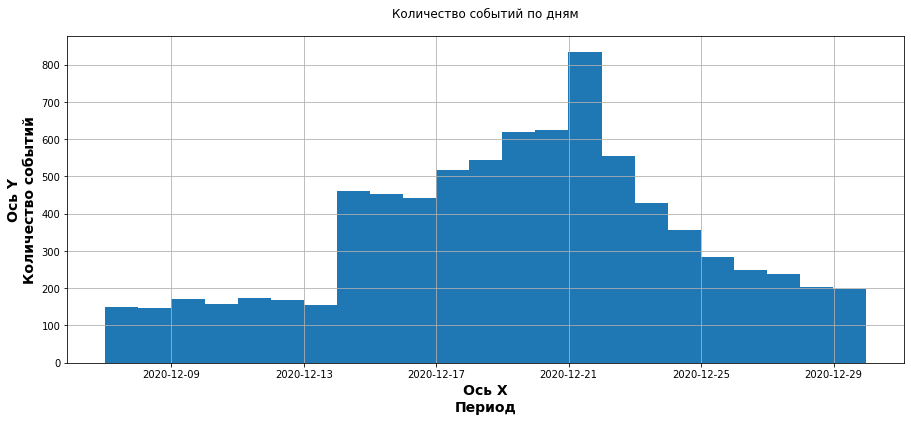

In [ ]:
# построим гистограмму по группе А
plt.figure(figsize=(15,6))
group_a['event_dt'].hist(bins=23)

plt.title('Количество событий по дням', pad=20)
plt.xlabel("Ось X\nПериод", fontsize=14, fontweight="bold")
plt.ylabel("Ось Y\nКоличество событий", fontsize=14, fontweight="bold");

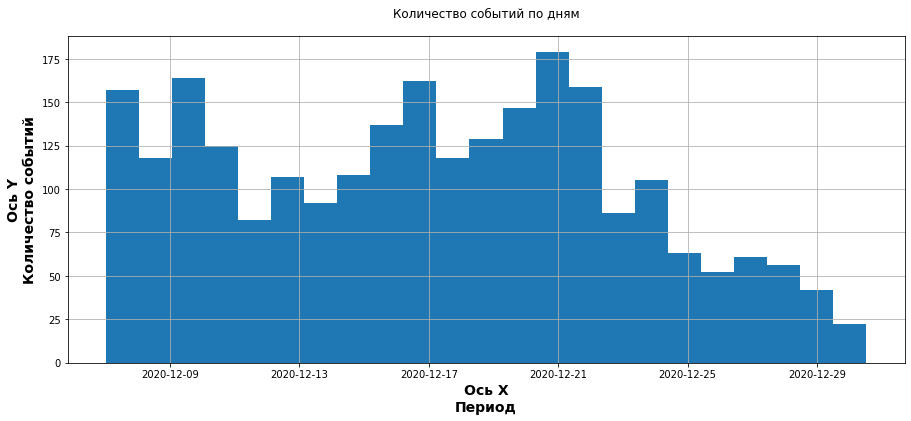

In [ ]:
# построим гистограмму по группе В
plt.figure(figsize=(15,6))
group_b['event_dt'].hist(bins=23)

plt.title('Количество событий по дням', pad=20)
plt.xlabel("Ось X\nПериод", fontsize=14, fontweight="bold")
plt.ylabel("Ось Y\nКоличество событий", fontsize=14, fontweight="bold");

Распределение событий по дням в группе А неравномерное, в начале периода - затишье, пик приходится на середину периода, далее примерно с 22 декабря - спад. Распределение по группе В наоборот, пользователи проявляют активность с самого старта теста, а спад зеркально группе А - начинается с 22 декабря.

### Конверсия в воронке в выборках на разных этапах

In [ ]:
# выведем пользователей по группе А
# посчитаем долю пользователей, которые хоть раз совершали событие
group_a = out.query('group=="A"')

cr_a = (group_a
        .groupby('event_name')
        .agg(number_of_users_a = ('user_id', 'nunique'))
        .sort_values('number_of_users_a', ascending=False)
        .assign(user_share_a = lambda x: x['number_of_users_a'] / group_a['user_id'].nunique()))

new_index_a = ['login', 'product_page', 'product_cart', 'purchase']
cr_a = cr_a.reindex(new_index_a)

cr_a


,number_of_users_a,user_share_a
event_name,,
login,2604,0.716566
product_page,1685,0.463676
product_cart,782,0.215190
purchase,833,0.229224


In [ ]:
# построим воронку событий и посмотрим, сколько пользователей побывали на каждом из этапов
# login - регистрация пользователя
# product_page - страница продукта
# product_cart - корзина
# purchase - покупка

fig = go.Figure(go.Funnel(
    y = new_index_a,
    x = cr_a['number_of_users_a'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous+percent total",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 3, 2, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(title="Воронка событий группы А", width=900, height=500)

fig.show()

Пользователи, которые побывали на первом этапе возьмем за общее количество пользователей (100%).

Тогда, на втором этапе побывали только 65% пользователей. На данном этапе теряется больше всего пользователей.

Доля пользователей, которая доходит от регистрации до покупки составляет всего 32%.

In [ ]:
# выведем пользователей по группе B
# посчитаем долю пользователей, которые хоть раз совершали событие

group_b = out.query('group=="B"')

cr_b = (group_b
        .groupby('event_name')
        .agg(number_of_users_b = ('user_id', 'nunique'))
        .sort_values('number_of_users_b', ascending=False)
        .assign(user_share_b = lambda x: x['number_of_users_b'] / group_b['user_id'].nunique()))

new_index_b = ['login', 'product_page', 'product_cart', 'purchase']
cr_b = cr_b.reindex(new_index_b)

cr_b

,number_of_users_b,user_share_b
event_name,,
login,877,0.322782
product_page,493,0.181450
product_cart,244,0.089805
purchase,249,0.091645


In [ ]:
# построим воронку событий и посмотрим, сколько пользователей побывали на каждом из этапов
# login - регистрация пользователя
# product_page - страница продукта
# product_cart - корзина
# purchase - покупка

fig = go.Figure(go.Funnel(
    y = new_index_b,
    x = cr_b['number_of_users_b'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous+percent total",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"],
    "line": {"width": [4, 3, 2, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.update_layout(title="Воронка событий группы B", width=900, height=500)

fig.show()

Пользователи, которые побывали на первом этапе возьмем за общее количество пользователей (100%).

Тогда, на втором этапе побывали только 56% пользователей. На данном этапе потеря пользователей выше чем в группе А.

Доля пользователей, которая доходит от регистрации до покупки составляет всего 28%.

Конверсия группы В ниже чем в группе А.

В данном разделе выявлено:
- количество событий на пользователя распределены равномерно как в среднем так и по медиане
- распределение событий по дням в обеих группах неравномерное
- по группе А конверсия от регистрации до покупки составляет 32%
- по группе В конверсия от регистрации до покупки составляет 28%

# 5. Оценка результатов A/B-тестирования

## Результаты A/B-тестирования

### Количество пользователей по группам

In [ ]:
# посмотрим еще раз, какое количество пользователей относятся к каждой группе
out.groupby('group')['user_id'].nunique().to_frame()

,user_id
group,
A,3634
B,2717


In [ ]:
# выведем информацию по событиям по каждой группе
users_by_events = out.pivot_table(index = 'group',
                                   columns = 'event_name',
                                   values = 'user_id',
                                   aggfunc = 'nunique').reset_index()
users_by_events

event_name,group,login,product_cart,product_page,purchase
0,A,2604,782,1685,833
1,B,877,244,493,249


In [ ]:
# добавим таблице users_by_events столбец с количеством пользователей в каждой из групп:
users_total = out.groupby('group')['user_id'].nunique()
users_by_events['users_total'] = users_by_events['group'].apply(lambda x: users_total.loc[x])
users_by_events = users_by_events.set_index('group')
users_by_events

event_name,login,product_cart,product_page,purchase,users_total
group,,,,,
A,2604,782,1685,833,3634
B,877,244,493,249,2717


Самым популярным событием для обеих групп становится регистрация. 

Для проверки гипотез возьмем только пользователей реально поучаствовавших в тесте, т.е. совершивших хотя бы одно событие. Для простоты можно взять количество пользователей с события login, это почти 100%

### Проверка гипотез

**Сформулируем гипотезы**
- Нулевая: конверсия группы А равна конверсии группы В.
- Альтернативная: конверсия группы А не равна конверсии группы В.

Проверять гипотезу будем при помощи Z-критерия.

In [ ]:
# напишем функцию для проверки
def st_test(part0, part1, total0, total1, alpha):  
    p1 = part0 / total0 
    p2 = part1 / total1 
    p_combined = (part0 + part1) / (total0 + total1) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [ ]:
pd.options.display.max_colwidth = 150

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу"]

for i in range(1):
    group_1 = 'A'
    current_row = users_by_events.loc[group_1]
    group_2 = 'B'
    for event_number in range(4):
        curr_event = users_by_events.columns[event_number]
        p_value_result = st_test(current_row[curr_event], 
                                       users_by_events[curr_event][group_2],
                                       current_row['login'],
                                       users_by_events['login'][group_2],
                                       alpha = 0.01
                               )
        new_row = {'Группа_1': group_1,
                   'Группа_2': group_2,
                   'Событие': users_by_events.columns[event_number],
                   'p_alpha': 0.01,
                   'p_value': round(p_value_result, 5),
                   'Результат': result_options[int(p_value_result >= 0.05)]}
        AB_pivot = AB_pivot.append([new_row])

AB_pivot.index = range(len(AB_pivot))
AB_pivot

<ipython-input-46-f20972d69fe1>:7: RuntimeWarning:

invalid value encountered in double_scalars



,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,A,B,login,0.01,NaN,Отвергаем нулевую гипотезу - между долями есть статзначимая разница
1,A,B,product_cart,0.01,0.21469,Не получилось отвергнуть нулевую гипотезу
2,A,B,product_page,0.01,0.00001,Отвергаем нулевую гипотезу - между долями есть статзначимая разница
3,A,B,purchase,0.01,0.04652,Отвергаем нулевую гипотезу - между долями есть статзначимая разница


Статзначимые отличия обнаружены во всех событиях, кроме product_cart.

Мы проводим множественный тест (берем несколько выборок из одного и того же набора данных). Особенность данного теста в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Поэтому скорректируем наши конечные p_value для сравнения их значений с alpha, для этого выберем метод Шидака.

In [ ]:
# пересчитаем данные по таблице (столбец p_value) и обновим выводы, если это потребуется (столбец Результат)
pd.options.display.max_colwidth = 150

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу"]

pvalues_corr_list = []  # откорректированные p-value
final_results = []  # итоговые результаты (отклоняем или нет)

for i in range(0, len(AB_pivot), 4):
    pvalues_list = AB_pivot.loc[i:i+3, 'p_value'].tolist()
    results, p_value_corr, _, _ = multipletests(pvalues_list, method='holm-sidak')
    pvalues_corr_list.extend([round(x, 5) for x in p_value_corr])
    final_results.extend([result_options[0] if x else result_options[1] for x in results])

AB_pivot = AB_pivot.drop('Результат', axis=1)
AB_pivot['p_value_corr'] = pvalues_corr_list
AB_pivot['Итоговый результат'] = final_results

AB_pivot

,Группа_1,Группа_2,Событие,p_alpha,p_value,p_value_corr,Итоговый результат
0,A,B,login,0.01,NaN,NaN,Не получилось отвергнуть нулевую гипотезу
1,A,B,product_cart,0.01,0.21469,0.38329,Не получилось отвергнуть нулевую гипотезу
2,A,B,product_page,0.01,0.00001,0.00004,Отвергаем нулевую гипотезу - между долями есть статзначимая разница
3,A,B,purchase,0.01,0.04652,0.13317,Не получилось отвергнуть нулевую гипотезу


*Результаты* изменились, внесённые изменения никак не повлияли на метрики и на поведения пользователей на трех шагах из четырех

# 6. Выводы и общее заключение о корректности проведения теста

Исходя из полученных данных и проведенной обработки информации

**Вывод:**
- количество событий на пользователя распределены равномерно как в среднем так и по медиане
- распределение событий по дням в обеих группах неравномерное
- по группе А конверсия от регистрации до покупки составляет 32%
- по группе В конверсия от регистрации до покупки составляет 28%
- самым популярным событием для обеих групп является регистрация.
- статзначимые отличия обнаружены

**Общее заключение о корректности проведения теста**
- выявлены несовпадения ТЗ и проведенного теста 
  - в дате остановки теста
  - в доле новых пользователей из Европы: разница составляет 1,2% в меньшую сторону.
  - в количестве участников теста: меньше запланированого
  - период проведения теста пересекается с периодами двух мерояприятий
  - различие в количестве пользователей в группах
  

  


**Описание шагов исследования:**

1. Загрузка данных и подготовка их к анализу
- обзор данных

2. Предобработка данных
- преобразование типов
- проверка пропущенных значений и дубликатов (описать их природу)

3. Оценка корректности проведения теста
- проверка корректности всех пунктов технического задания
- время проведения теста (что оно не совпадает с маркетинговыми и другими активностями)
- аудитория теста (нет ли пересечений с конкурирующим тестом и нет ли пользователей, участвующих в двух группах теста одновременно; проверка равномерности распределения пользователей по тестовым группам и правильность их формирования)

4. Исследовательский анализ данных
- равность распределения количества событий на пользователя в выборках
- распределение числа событий в выборках по дням
- изменение конверсии в воронке в выборках на разных этапах
- выявление особенностей в данных перед началом A/B-тестирования

5. Оценка результатов A/B-тестирования
- результаты A/B-тестирования
- проверка статистической разницы долей z-критерием

6. Выводы и общее заключение о корректности проведения теста



**Прежде чем приступать к A/B-тестированию необходимо учитывать следующие особенности:**
- цель теста
- определение метрики (например, Conversion Rate)
- формулирование гипотезы (например, "Ожидаем, что изменения вызовут рост конверсии не менее чем на 10%")
- проверка количества пользователей в различных группах (различие не более, чем на 1%)
- равномерность выборок
- достаточный период теста
